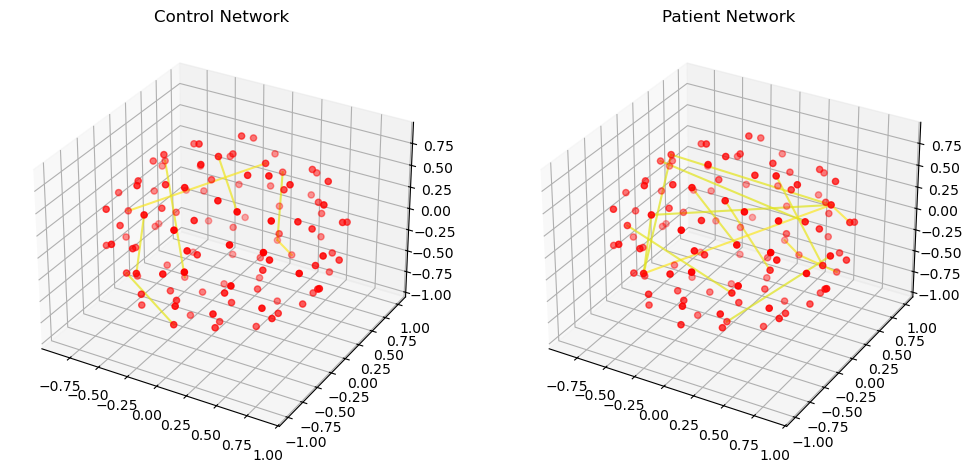

Node  CtrlClust PatClust  ClustDiff CtrlClose PatClose  CloseDiff CtrlDeg   PatDeg    DegDiff   
------------------------------------------------------------------------------------------------
0     0.5591    0.5693    0.0103    1.7933    1.7516    0.0418    65.6516   66.7690   1.1174    
1     0.5631    0.5594    0.0037    1.7837    1.8041    0.0205    66.6384   65.2448   1.3936    
2     0.5623    0.5550    0.0073    1.7669    1.8171    0.0501    66.1122   64.5439   1.5683    
3     0.5487    0.5493    0.0006    1.8601    1.8656    0.0055    64.1567   63.7470   0.4097    
4     0.5388    0.5470    0.0082    1.8801    1.8427    0.0374    61.9383   62.7507   0.8124    
5     0.5400    0.5503    0.0103    1.8717    1.8530    0.0187    62.1868   63.6580   1.4712    
6     0.5566    0.5707    0.0141    1.8086    1.7471    0.0616    65.4228   67.1985   1.7758    
7     0.5551    0.5731    0.0180    1.8241    1.7201    0.1040    65.2417   67.4776   2.2358    
8     0.5548    0.5630    0.00

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.io import loadmat
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as mcolors

# Function to load and process correlation matrix
def load_and_process_matrix(file_path):
    """
    Load the correlation matrix, apply linear transformation, and normalize weights.
    """
    data = loadmat(file_path)
    # Assuming the correlation matrix is under the key 'connectivity' or 'correlation'
    matrix = None
    for key in data.keys():
        if isinstance(data[key], np.ndarray) and data[key].shape[0] == data[key].shape[1]:
            matrix = data[key]
            break
    if matrix is None:
        raise ValueError("Correlation matrix not found in the file.")

    # Apply linear transformation: map [-1, 1] to [0, 1]
    matrix_transformed = (matrix + 1) / 2.0
    np.fill_diagonal(matrix_transformed, 0)  # Remove self-loops

    # Normalize edge weights
    max_weight = np.max(matrix_transformed)
    if max_weight > 0:
        matrix_transformed = matrix_transformed / max_weight

    return matrix_transformed

# Function to create graph from a weighted adjacency matrix
def create_weighted_graph(matrix):
    """
    Create a NetworkX graph from the weighted adjacency matrix.
    """
    G = nx.from_numpy_array(matrix)
    return G

# Function to visualize two aligned graphs in 3D
def visualize_aligned_graphs_3d(G_control, G_patient, title="Aligned Brain Networks"):
    """
    Visualize two aligned graphs in 3D using NetworkX and Matplotlib.
    Color edges based on their weights and align node positions for both graphs.
    Only edges with weights close to 0 or 1 will be shown.
    """
    # Generate consistent node positions for both graphs
    pos = nx.spring_layout(G_control, dim=3, seed=42)

    fig = plt.figure(figsize=(12, 6))

    # Plot Control Graph
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.set_title("Control Network")
    draw_filtered_graph(G_control, pos, ax1)

    # Plot Patient Graph
    ax2 = fig.add_subplot(122, projection='3d')
    ax2.set_title("Patient Network")
    draw_filtered_graph(G_patient, pos, ax2)

    plt.show()

# Helper function to draw a filtered graph in 3D with color-coded edges
def draw_filtered_graph(G, pos, ax):
    """
    Draws a 3D graph with nodes and edges where edges are filtered based on weight.
    """
    # Define colormap for edge weights
    colormap = plt.cm.viridis
    norm = mcolors.Normalize(vmin=0, vmax=1)

    # Draw nodes
    x = [pos[i][0] for i in G.nodes()]
    y = [pos[i][1] for i in G.nodes()]
    z = [pos[i][2] for i in G.nodes()]
    ax.scatter(x, y, z, c='red', s=20, label='Nodes')

    # Draw edges filtered by weight (near 0 or 1)
    for edge in G.edges(data=True):
        weight = edge[2].get('weight', 0)
        if abs(weight - 1) < 0.05 or abs(weight) < 0.05:  # Show edges near 0 or 1
            color = colormap(norm(weight))
            x_edge = [pos[edge[0]][0], pos[edge[1]][0]]
            y_edge = [pos[edge[0]][1], pos[edge[1]][1]]
            z_edge = [pos[edge[0]][2], pos[edge[1]][2]]
            ax.plot(x_edge, y_edge, z_edge, c=color, alpha=0.7, linewidth=1.5)

# Function to compute clustering coefficients
def compute_clustering_coefficients(G):
    """
    Compute the weighted clustering coefficients for all nodes.
    """
    clustering = nx.clustering(G, weight='weight')
    return clustering

# Function to compute closeness centrality
def compute_closeness_centrality(G):
    """
    Compute the closeness centrality for all nodes.
    """
    closeness = nx.closeness_centrality(G, distance='weight')
    return closeness

# Load and process data for both control and patient
data_control_path = 'sub-control032057_AAL116_correlation_matrix.mat'
data_patient_path = 'sub-patient032085_AAL116_correlation_matrix.mat'

# Process and create graphs for control and patient
data_control = load_and_process_matrix(data_control_path)
data_patient = load_and_process_matrix(data_patient_path)

G_control = create_weighted_graph(data_control)
G_patient = create_weighted_graph(data_patient)

# Visualize aligned graphs
visualize_aligned_graphs_3d(G_control, G_patient, title="Aligned Control vs Patient Brain Networks")

# Compute clustering coefficients and closeness centrality
clustering_control = compute_clustering_coefficients(G_control)
clustering_patient = compute_clustering_coefficients(G_patient)

closeness_control = compute_closeness_centrality(G_control)
closeness_patient = compute_closeness_centrality(G_patient)

# Function to compute degree centrality
def compute_degree_centrality(G):
    """
    Compute the degree centrality for all nodes.
    """
    degree_centrality = {node: sum(weight for _, _, weight in G.edges(node, data='weight')) for node in G.nodes()}
    return degree_centrality

# Compute degree centrality for control and patient graphs
degree_control = compute_degree_centrality(G_control)
degree_patient = compute_degree_centrality(G_patient)

def compare_metrics(clustering1, clustering2, closeness1, closeness2, degree1, degree2):
    """
    Compare clustering coefficients, closeness centrality, and degree centrality for each node.
    Return nodes with the most significant differences.
    """
    # Define header
    header = (f"{'Node':<6}{'CtrlClust':<10}{'PatClust':<10}{'ClustDiff':<10}"
              f"{'CtrlClose':<10}{'PatClose':<10}{'CloseDiff':<10}"
              f"{'CtrlDeg':<10}{'PatDeg':<10}{'DegDiff':<10}")
    print(header)
    print("-" * len(header))

    # Store differences for later sorting
    diff_nodes = []
    for node in clustering1:
        clustering_diff = abs(clustering1[node] - clustering2[node])
        closeness_diff = abs(closeness1[node] - closeness2[node])
        degree_diff = abs(degree1[node] - degree2[node])
        diff_nodes.append((node, clustering_diff, closeness_diff, degree_diff))

        # Print current node's metrics
        print(f"{node:<6}{clustering1[node]:<10.4f}{clustering2[node]:<10.4f}{clustering_diff:<10.4f}"
              f"{closeness1[node]:<10.4f}{closeness2[node]:<10.4f}{closeness_diff:<10.4f}"
              f"{degree1[node]:<10.4f}{degree2[node]:<10.4f}{degree_diff:<10.4f}")

    # Sort nodes by the sum of differences across all metrics
    diff_nodes.sort(key=lambda x: x[1] + x[2] + x[3], reverse=True)

    print("\nNodes with the Most Significant Differences:")
    print("-" * 40)
    for node, c_diff, cl_diff, d_diff in diff_nodes[:5]:
        print(f"Node {node}: ClustDiff = {c_diff:.4f}, CloseDiff = {cl_diff:.4f}, DegDiff = {d_diff:.4f}")

    return diff_nodes[:5]


# Print comparison results and nodes with the most significant differences
top_differences = compare_metrics(
    clustering_control, clustering_patient,
    closeness_control, closeness_patient,
    degree_control, degree_patient
)

